If you are unfamiliar with scipy's ordinary differential equations, this is a great start.

https://ipython-books.github.io/123-simulating-an-ordinary-differential-equation-with-scipy/

If you need some rewind from dynamic system, Brigham Young University provides excellent and free materials.

The demonstration of HIV infection is a great example of ordinary differential equations.

https://apmonitor.com/pdc/index.php/Main/SimulateHIV

The demonstration of dual heater first ordered physics model is a great example of the non-linear least square estimation on dynamic system.

https://apmonitor.com/pdc/index.php/Main/ArduinoEstimation2

In [1]:
import numpy as np
from scipy.integrate import odeint
from scipy.optimize import minimize
import matplotlib.pyplot as plt
import datetime as dt
import os
import re
import pandas as pd
import random as rd
os.chdir('k:/a')

In [2]:
global gradientcolor

In [3]:
gradientcolor=['#cfcaca',
 '#cec9c9',
 '#cdc8c8',
 '#ccc7c7',
 '#cbc7c6',
 '#cac6c5',
 '#c9c5c4',
 '#c8c4c3',
 '#c7c3c3',
 '#c6c2c2',
 '#c5c1c1',
 '#c4c0c0',
 '#c3c0bf',
 '#c2bfbe',
 '#c1bebd',
 '#c0bdbc',
 '#c0bcbb',
 '#bfbbba',
 '#bebab9',
 '#bdb9b8',
 '#bcb9b7',
 '#bbb8b6',
 '#bab7b5',
 '#b9b6b4',
 '#b8b5b4',
 '#b7b4b3',
 '#b6b3b2',
 '#b5b2b1',
 '#b4b2b0',
 '#b3b1af',
 '#b2b0ae',
 '#b1afad',
 '#b0aeac',
 '#afadab',
 '#adaca9',
 '#acaaa8',
 '#aba9a7',
 '#aaa8a6',
 '#a9a7a5',
 '#a7a6a3',
 '#a6a5a2',
 '#a5a4a1',
 '#a4a3a0',
 '#a3a19f',
 '#a1a09d',
 '#a09f9c',
 '#9f9e9b',
 '#9e9d9a',
 '#9d9c99',
 '#9c9b98',
 '#9a9a96',
 '#999895',
 '#989794',
 '#979693',
 '#969592',
 '#949490',
 '#93938f',
 '#92928e',
 '#91918d',
 '#908f8c',
 '#8e8e8a',
 '#8d8d89',
 '#8c8c88',
 '#8a8a86',
 '#888884',
 '#858582',
 '#838380',
 '#81817d',
 '#7f7f7b',
 '#7c7c79',
 '#7a7a77',
 '#787875',
 '#767673',
 '#737471',
 '#71716f',
 '#6f6f6c',
 '#6d6d6a',
 '#6a6b68',
 '#686966',
 '#666664',
 '#646462',
 '#616260',
 '#5f605e',
 '#5d5d5b',
 '#5b5b59',
 '#585957',
 '#565755',
 '#545553',
 '#525251',
 '#4f504f',
 '#4d4e4d',
 '#4b4c4a',
 '#494948',
 '#464746',
 '#444544',
 '#434443',
 '#414241',
 '#404140',
 '#3f403f',
 '#3e3f3e',
 '#3c3d3c',
 '#3b3c3b',
 '#3a3b3a',
 '#393939',
 '#373837',
 '#363736',
 '#353635',
 '#343434',
 '#323332',
 '#313231',
 '#303030',
 '#2f2f2f',
 '#2d2e2d',
 '#2c2c2c',
 '#2b2b2b',
 '#2a2a2a',
 '#282928',
 '#272727',
 '#262626',
 '#252525',
 '#232323',
 '#222222',
 '#212121',
 '#202020',
 '#1e1e1e',
 '#1d1d1d',
 '#1c1c1c',
 '#1c1c1c',
]

In [4]:
#get demographic data
def get_demographic(un_total,un_birth,un_death,country,year):
    
    #the unit is in '000
    population=un_total['Value'][un_total['Country or Area']==country][un_total['Year(s)']==year][un_total['Variant']=='Medium'].item()*1000
    population0=un_total['Value'][un_total['Country or Area']==country][un_total['Year(s)']==(year-1)][un_total['Variant']=='Medium'].item()*1000
    
    #for some reason, un doesnt provide crude rate per year, only annual rate per 5 year
    yearrange='%s-%s'%(2000+(year-2000)//5*5,2005+(year-2000)//5*5)
    
    #crude birth and death rate per 1000 people
    birth=un_birth['Value'][un_birth['Country or Area']==country][un_birth['Year(s)']==yearrange][un_birth['Variant']=='Medium'].item()/1000
    death=un_death['Value'][un_death['Country or Area']==country][un_death['Year(s)']==yearrange][un_death['Variant']=='Medium'].item()/1000
    
    #avoid python float error
    birth=round(birth,6)
    death=round(death,6)
    population=round(population,0)
    population0=round(population0,0)
    
    return (birth,death,population,population0)

In [5]:
#cleansing data
def prepare_data(df,demographic,country):
    
    birth,death,population,population0=demographic
    
    data=df.loc[df['Number recovered'][df['Country']==country].dropna().index]
    data.set_index('report date',inplace=True)
    data.index=pd.to_datetime(data.index)

    #Number recovered denotes R in the dynamic system
    #Number of deaths denotes D in the dynamic system
    data=data[['Number recovered','Number of deaths','Cumulative number of cases']].copy(deep=True)

    #currently infected denotes I in the dynamic system
    data['currently infected']=data['Cumulative number of cases']-data['Number recovered']-data['Number of deaths']

    #time denotes t in the dynamic system
    dif=pd.Series(data.index).diff()
    data['time']=dif.fillna('0').apply(lambda x: re.findall('\d+',str(x))[0]).astype(int).cumsum().tolist()

    #the tricky part is the susceptible
    #it is the total population minus cumulated cases
    #and the total population should also include natural birth and death

    #first we need to convert annual rate to daily rate as we got daily data
    birthdaily=(birth+1)**(1/365)-1

    #the case of daily death rate is slightly more complicated
    #we need to exclude virus caused fatality
    #the revised rate is a tiny change in the decimals
    death_nonvirus=round((death*population),0)-df['Number of deaths'][df['Country']==country][pd.to_datetime(df['report date'])<'2004-01-01'].iloc[-1]
    realdeath=death_nonvirus/population
    deathdaily=(realdeath+1)**(1/365)-1

    #the daily population projection excludes immigration and emigration
    #first, its challenging to find daily immigration and emigration data
    #i am pretty sure the government has it but i cannot find it for free
    #second, when the quarantines kicked in, no flights were allowed
    #many places in asia became a closed system
    ppl=pd.DataFrame()
    ppl['population']=[round(population0*((1+birthdaily-deathdaily)**i),0) for i in range(365)]
    ppl['report date']=[pd.to_datetime('2003-01-01')+dt.timedelta(days=i) for i in range(365)]
    ppl.set_index('report date',inplace=True)
    
    #merge
    data=data.merge(ppl,left_index=True,right_index=True)

    #susceptible denotes S in the dynamic system
    data['susceptible']=data['population']-data['Cumulative number of cases']
    
    data['alpha']=birthdaily
    data['gamma']=deathdaily
    data['country']=country
    
    return data

In [6]:
#modified version of sir model with vital dynamic
#include natural birth, natural death and virus death
def SIRmodel(z,t,known,unknown):
    
    alpha,gamma=known
    beta,delta,epsilon=unknown
    
    S=z[0]
    I=z[1]
    R=z[2]
    
    #we dont include virus caused death in the equations
    #becuz it is not used in any equation
    #its better to have a matrix with full rank
    dSdt=alpha*(S+I+R)-gamma*S-beta*S*I
    dIdt=beta*S*I-(gamma+delta)*I-epsilon*I
    dRdt=epsilon*I
    
    dzdt=[dSdt,dIdt,dRdt]
    
    return dzdt

In [7]:
#put all differential equations together
def dynamicsystem(unknown):
    
    t=data['time'].tolist()
    
    alpha=data['alpha'].iloc[0]
    gamma=data['gamma'].iloc[0]
    
    #create a list to store fitted values
    fitted=np.zeros((len(t),3))
    
    #initial value
    fitted[0,0]=data['susceptible'].iloc[0]
    fitted[0,1]=data['currently infected'].iloc[0]
    fitted[0,2]=data['Number recovered'].iloc[0]
    
    z0=fitted[0]
    
    #we compute the fitted value via iterations
    #becuz this way is compatible with non-linear least square
    for i in range(1,len(t)):
        
        #no report on sunday
        #i suppose WHO staff go to church as well
        #no, i am kidding, they deserve a break as well
        #as the time interval is not consistent
        #we need to pass the variable as a list
        interval=[t[i-1],t[i]]
        
        z=odeint(SIRmodel,z0,interval,args=((alpha,gamma),unknown))
        
        #each iteration, the last fitted value becomes the initial value
        z0=z[-1]
        
        #we update fitted via each iteration
        fitted[i]=z[-1]
                
    return fitted

In [8]:
#the cost of least square is the sum of squared error
def costfunction(unknown):
    
    fitted=dynamicsystem(unknown)
    
    cost=0.0
    
    #S,I,R
    actual=['susceptible','currently infected','Number recovered']
    
    #we have 3 ordinary differential equations
    #so we include 3 errors in each round
    #and we standardize the errors by the actual values
    for i in range(len(data)):
        for j in range(len(actual)):
            
            #sometimes the actual data may be zero
            #we cannot standardize the error by division
            if data[actual[j]].iloc[i]==0:
                if round(fitted[i,j],0)>1:
                    cost+=1
                else:
                    cost+=0
            else:
                cost+=((fitted[i,j]-data[actual[j]].iloc[i])/data[actual[j]].iloc[i])**2 
    
    return cost

In [9]:
#using non linear least square to estimate the parameters of dynamic system
#as we can only find the local minimum
#the initial value is crucial to the result
def estimate(diagnosis=False,beta_guess=0.001,delta_guess=0.01,epsilon_guess=0.02,**kwargs):
       
    #sum of squared error from initial guess
    sse=costfunction((beta_guess,delta_guess,epsilon_guess))
    
    if diagnosis:
        print(f'Initial SSE: {round(sse,2)}')
    
    #according to rule of thumb, we use nelder-mead
    #actually i exhausted all possibilities
    #this one was the best empirical result
    #the shortcoming is nelder-mead doesnt take constraints
    #all rates should be bounded by 0 and 1
    lse=minimize(costfunction,x0=(beta_guess,delta_guess,epsilon_guess),
                 method='Nelder-Mead')
        
    if lse.success:   
        
        #sum of squared error from successful result
        beta,delta,epsilon=lse.x
        sse=costfunction((beta,delta,epsilon))
        if diagnosis:
            print(f'Result SSE: {round(sse,2)}')
        return beta,delta,epsilon
        
    else:
        #if it doesnt converge to local minimum
        #we print the result and find out why
        if diagnosis:
            print(lse)
        return 0,0,0

In [10]:
#generate final outcome for in sample data
def create_in_sample_output(diagnosis=False,**kwargs):
    
    #estimate parameters
    beta,delta,epsilon=estimate(**kwargs)
    
    if beta<=0 or delta<=0 or epsilon<=0 or beta>1 or delta>1 or epsilon>1:
        if diagnosis:
            print('\nFailed\n')
        return None
    
    if diagnosis:
        print(f'\nInfection Rate: {round(beta,10)}')
        print(f'Fatality Rate: {round(delta,5)}')
        print(f'Recovery Rate: {round(epsilon,5)}\n')
    

    #show reproductive ratio
    R0=round(beta*data['susceptible'].iloc[0]/(data['gamma'].iloc[0]+delta+epsilon),5)
    data['R0']=R0
    if diagnosis:
        print(f'\nBasic Reproductive Ratio: {R0}\n')

    #get model predictions
    fitted=dynamicsystem((beta,delta,epsilon))

    data['susceptible fitted']=fitted[:,0]
    data['infected fitted']=fitted[:,1]
    data['recovered fitted']=fitted[:,2]

    #as death is not in differential equations
    #we need to compute it separately
    D=[data['Number of deaths'].iloc[0]]

    for i in range(1,len(data)):
        D.append(round(D[-1]+delta*data['infected fitted'].iloc[i],0))

    data['death fitted']=D

    #convert float to int
    for i in data.columns:
        if 'fitted' in i:
            data[i]=data[i].apply(lambda x: round(x,0)).astype(int)
            
    #sum of squared error of death
    sse_d=sum((data['Number of deaths']-data['death fitted']).apply(lambda x:x**2))
            
    return sse_d

In [11]:
#using random initial value to find the best starting point
#the best start point is defined by the minimum SSE of D
#even D is not in our differential equations
#we believe the global minimum should successfully capture D as well
#in reality, its not a good idea to run 10k times
#it took the whole night to get a result
#luckily i chose to sleep it off
def find_init(num=10000):
    D={}

    for _ in range(num):

        beta_random=rd.randint(1,1e+10)/10**(rd.randint(11,21))
        delta_random=rd.randint(1,1e+10)/10**(rd.randint(11,21))
        epsilon_random=rd.randint(1,1e+10)/10**(rd.randint(11,21))

        try:
            temp=create_in_sample_output(beta_guess=beta_random,
                                         delta_guess=delta_random,
                                         epsilon_guess=epsilon_random)
            if temp:
                D[(beta_random,delta_random,epsilon_random)]=temp
        except:
            pass
        
    return dict(sorted(D.items(),key=lambda x:x[1]))

In [12]:
#the best initial guess should suffice to 3 criteria
#smallest death sse,smallest overall sse including death and largest r0
#and the default weight is slightly leaned towards death sse
def find_best_init(D,weight=[0.4,0.3]):
    
    global data

    D2={}
    D3={}
    
    databackup=data.copy(deep=True)
    
    #calculate the overall sum of squared error for each initial guess
    #this sum of squared error includes death as well
    for i in D:
        data=databackup.copy(deep=True)
        beta_guess,delta_guess,epsilon_guess=i
        if create_in_sample_output(beta_guess=beta_guess, delta_guess=delta_guess):
            sse=[((data['death fitted']-data['Number of deaths'])/data['Number of deaths'])**2,
            ((data['currently infected']-data['infected fitted'])/data['currently infected'])**2,
            ((data['susceptible']-data['susceptible fitted'])/data['susceptible'])**2,
            ((data['Number recovered']-data['recovered fitted'])/data['Number recovered'])**2]

            totalsse=sum([sum(i) for i in sse])

            D2[(beta_guess,delta_guess,epsilon_guess)]=totalsse
            D3[(beta_guess,delta_guess,epsilon_guess)]=(data['R0'].iloc[0].item()-1)**2

    D2=dict(sorted(D2.items(),key=lambda x:x[1]))
    D3=dict(sorted(D3.items(),key=lambda x:x[1]))
    
    #the best initial guess should balance the overall sse, R0 and death sse
    D4={}

    for i in D2:
        ind1=list(D.keys()).index(i)
        ind2=list(D2.keys()).index(i)        
        ind3=list(D3.keys()).index(i)

        D4[i]=ind1*weight[0]+ind2*weight[1]+ind3*(1-sum(weight))

    D4=dict(sorted(D4.items(),key=lambda x:x[1]))
    
    return D4

In [13]:
#single plot for in sample data
def plot_in_sample(actualcol,fittedcol,title,fig,order,color1,color2):    
    
    ax=fig.add_subplot(order)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    plt.title(data['country'].iloc[0]+'\n'+title)
    plt.ylabel('number')
    plt.xlabel('date')
    
    data[actualcol].plot(label='Actual',alpha=0.9,c=color1)
    data[fittedcol].plot(label='Fitted',alpha=0.9,c=color2)
    
    plt.legend(loc=0)

In [14]:
#plot S,I,R,D in a 2 by 2 figure for in sample data
def plot_all(savefig=True):
    
    iteration=[('susceptible','susceptible fitted','Susceptible Population',221,'#1f6521','#d6ce15'),
    ('currently infected','infected fitted','Currently Infected',222,'#f13c20','#f79e02'),
    ('Number recovered','recovered fitted','Recovered Patients',223,'#4c495d','#de8cf0'),
    ('Number of deaths','death fitted','Virus-caused Death',224,'#4d6d9a','#99ced3')]

    fig=plt.figure(figsize=(12,8))

    for i in iteration:

        actualcol,fittedcol,title,order,color1,color2=i
        plot_in_sample(actualcol,fittedcol,title,fig,order,color1,color2)
    
    #avoid messed up title and xlabel 
    plt.tight_layout(pad=1.5)
    
    if savefig:
        figname=f"differential-SARS-{data['country'].iloc[0]}-in sample.png"
        plt.savefig(figname.lower())
    
    plt.show()

In [15]:
#single plot for out of sample data
def plot_outta_sample(actualcol,fittedcol,title,fig,order,color):    
    
    fitted_all=[i for i in data.columns if fittedcol in i]
    
    #using gradient color to plot
    colorlist=gradientcolor[0::int(len(gradientcolor)/len(fitted_all))]
    
    ax=fig.add_subplot(order)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    plt.title(data['country'].iloc[0]+'\n'+title)
    plt.ylabel('number')
    plt.xlabel('date')
    
    data[actualcol].plot(label='actual',alpha=0.9,c=color)
    
    #plot different percentage training data
    for i in range(len(fitted_all)):
        pct=float(fitted_all[i].split(' ')[0])
        data[fitted_all[i]].plot(label=f'{round(pct*100,0)}% training data',
                             alpha=0.75,c=colorlist[i])
    
    plt.legend(loc=0)  

In [16]:
#generate final outcome for out of sample data
def create_outta_sample_output(train_pct=[0.3,0.4,0.5,0.75,0.9],
                  train_init=[],savefig=True):
    
    #CRUCIAL
    #we need to change the length of training data inside this function
    #we need global data to echo the global definition outside of the function
    global data
    
    #make sure no error comes from input args
    if not train_init:
        train_init=[(0.001,0.01,0.02)]*len(train_pct)
    else:
        assert len(train_init)==len(train_pct),'train_pct and train_init length mismatch'        
        assert np.all([len(i)==3 for i in train_init]),'dimension of train_init elements should be 3'

    #backup global variable
    databackup=data.copy(deep=True)
    
    dict_est={}
    
    #using different percentage of training data to do cross validation
    for i in range(len(train_init)):
        
        pct=train_pct[i]
        init=train_init[i]
        
        data=databackup.iloc[:int(len(databackup)*pct)] 
                
        #estimate parameters
        beta,delta,epsilon=estimate(beta_guess=init[0],delta_guess=init[1],epsilon_guess=init[2])
        
        #only keep track of the successful ones
        if beta<=0 or delta<=0 or epsilon<=0 or beta>=1 or delta>=1 or epsilon>=1:
            pass
        else:
            dict_est[pct]=(beta,delta,epsilon)
    
    #back to the original time horizon
    data=databackup.copy(deep=True)  
        
    for pct in dict_est:
        
        #get model predictions
        fitted=dynamicsystem(dict_est[pct])

        data[f'{pct} susceptible fitted']=fitted[:,0]
        data[f'{pct} infected fitted']=fitted[:,1]
        data[f'{pct} recovered fitted']=fitted[:,2]    

        #as death is not in differential equations
        #we need to compute it separately
        D=[data['Number of deaths'].iloc[0]]
        
        for i in range(1,len(data)):
            D.append(round(D[-1]+delta*data[f'{pct} infected fitted'].iloc[i],0))
        
        data[f'{pct} death fitted']=D

    #convert float to int
    for i in data.columns:
        if 'fitted' in i:
            data[i]=data[i].apply(lambda x: round(x,0)).astype(int)
    
    #plot S,I,R,D in a 2 by 2 figure
    iteration=[('susceptible','susceptible fitted','Susceptible Population',221,'#00743f'),
    ('currently infected','infected fitted','Currently Infected',222,'#f13c20'),
    ('Number recovered','recovered fitted','Recovered Patients',223,'#841983'),
    ('Number of deaths','death fitted','Virus-caused Death',224,'#05acd3')]

    fig=plt.figure(figsize=(12,8))

    for i in iteration:

        actualcol,fittedcol,title,order,color=i
        plot_outta_sample(actualcol,fittedcol,title,fig,order,color)
    
    #avoid messed up title and xlabel
    plt.tight_layout(pad=1.5)
    
    if savefig:
        figname=f"differential-SARS-{data['country'].iloc[0]}-out of sample.png"
        plt.savefig(figname.lower())
    
    plt.show() 

In [17]:
un_birth=pd.read_csv('birth.csv')
un_death=pd.read_csv('death.csv')
un_total=pd.read_csv('total.csv')
df=pd.read_csv('grand-sars.csv')

In [18]:
var=locals()

mapping={'China, Hong Kong SAR': 'hk','Singapore': 'sg',
         'Canada': 'ca','United States of America':'us',
         'United Kingdom':'uk','Australia':'au',
         'France':'fr','Germany':'de','Italy':'it',
         'Philippines':'ph','Malaysia':'my',
         'Viet Nam': 'vn','Thailand': 'th',
         'Republic of Korea':'kr','India':'in',}

for i in mapping:
    var[mapping[i]+'demographic']=get_demographic(un_total,un_birth,un_death,i,2003)
    
    #the irritating part where different country names are used
    if i=='China, Hong Kong SAR':
        country='Hong Kong'
    elif i=='United States of America':
        country='United States'
    else:
        country=i
        
    var['data'+mapping[i]]=prepare_data(df,var[mapping[i]+'demographic'],country)

&nbsp;
### In-sample Data
&nbsp;

In [19]:
#using global variable is the worst idea
#but we need to call our dataframe inside the differential equations
#odeint prefers a clean dynamic system function with only numerical inputs
#therefore we have to define the dataframe as the global variable
global data

C:\ProgramData\Anaconda3\lib\site-packages\scipy\integrate\odepack.py:236: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)



Infection Rate: 5.4e-09
Fatality Rate: 0.01737
Recovery Rate: 0.05565


Basic Reproductive Ratio: 0.49283



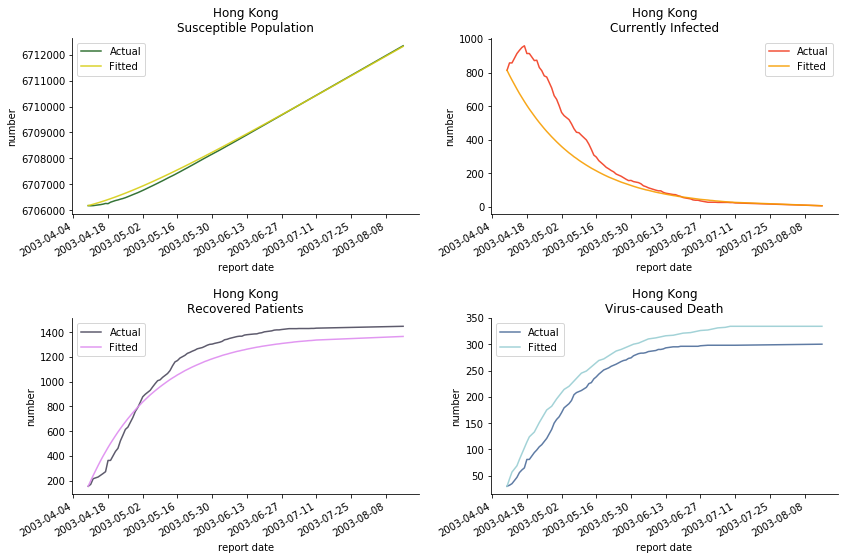

In [20]:
data=datahk.copy(deep=True)

if create_in_sample_output(diagnosis=True):
    plot_all()

C:\ProgramData\Anaconda3\lib\site-packages\scipy\integrate\odepack.py:236: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)



Infection Rate: 1.86e-08
Fatality Rate: 0.02478
Recovery Rate: 0.08159


Basic Reproductive Ratio: 0.72012



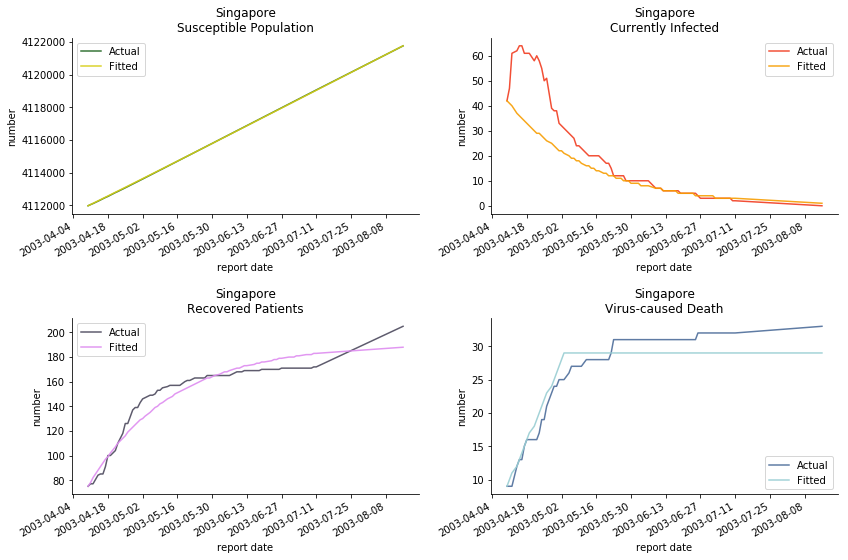

In [21]:
data=datasg.copy(deep=True)

if create_in_sample_output(diagnosis=True):
    plot_all()

In [22]:
# to find initial guess if needed
# data=dataus.copy(deep=True)
# D=find_init(num=200)
# D4=find_best_init(D)


Infection Rate: 1.8e-09
Fatality Rate: 0.02421
Recovery Rate: 0.06798


Basic Reproductive Ratio: 0.61973



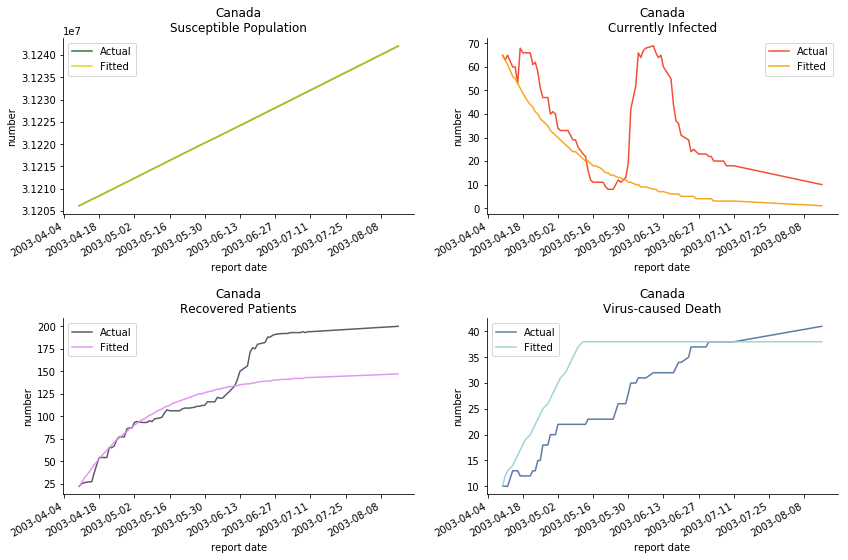

In [23]:
data=dataca.copy(deep=True)

if create_in_sample_output(beta_guess=8.8e-08, delta_guess=0.015, epsilon_guess=0.04,diagnosis=True):
    plot_all()

C:\ProgramData\Anaconda3\lib\site-packages\scipy\integrate\odepack.py:236: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)



Infection Rate: 1e-10
Fatality Rate: 0.03236
Recovery Rate: 0.01525


Basic Reproductive Ratio: 0.67579



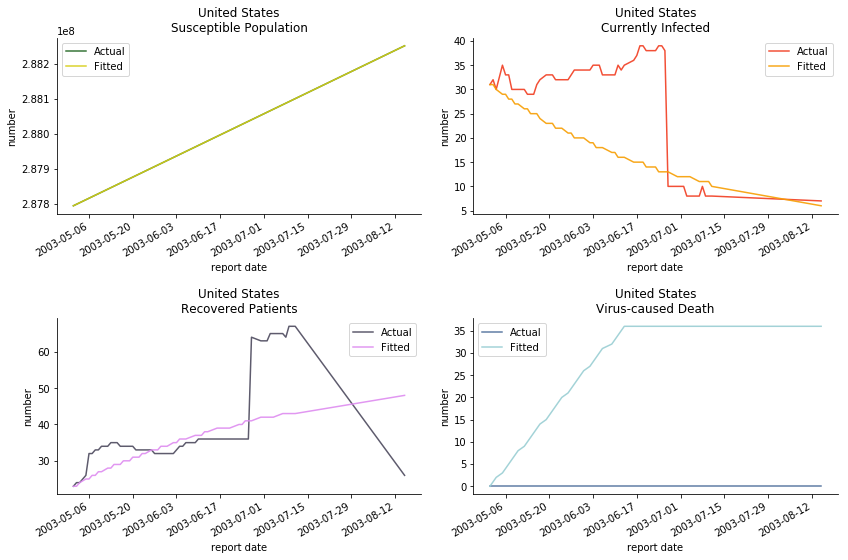

In [24]:
data=dataus.copy(deep=True)

if create_in_sample_output(beta_guess=8e-07,delta_guess=0.002,epsilon_guess=0.03,diagnosis=True):
    plot_all()


Infection Rate: 4e-10
Fatality Rate: 0.03884
Recovery Rate: 0.09382


Basic Reproductive Ratio: 0.24534



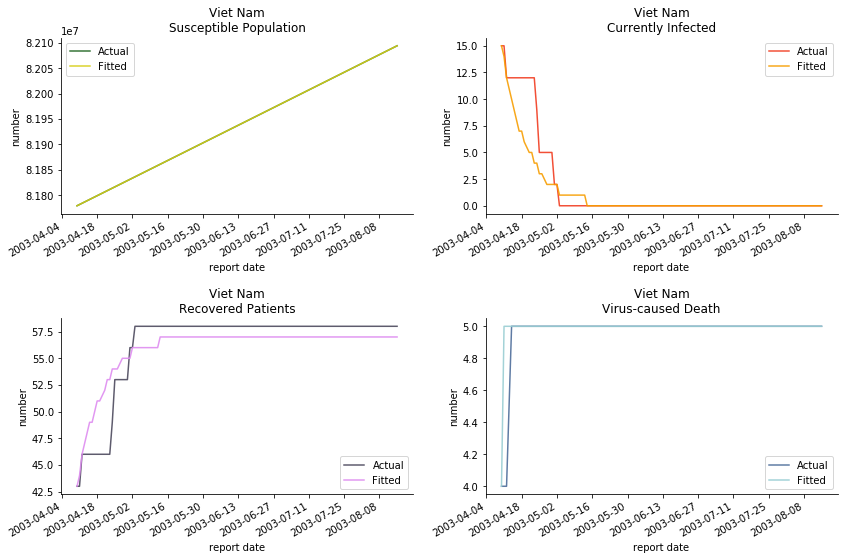

In [25]:
data=datavn.copy(deep=True)

if create_in_sample_output(beta_guess=8.8e-08,delta_guess=0.015,epsilon_guess=0.04,diagnosis=True):
    plot_all()

C:\ProgramData\Anaconda3\lib\site-packages\scipy\integrate\odepack.py:236: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)



Infection Rate: 2.3e-09
Fatality Rate: 0.02913
Recovery Rate: 0.05191


Basic Reproductive Ratio: 0.67513



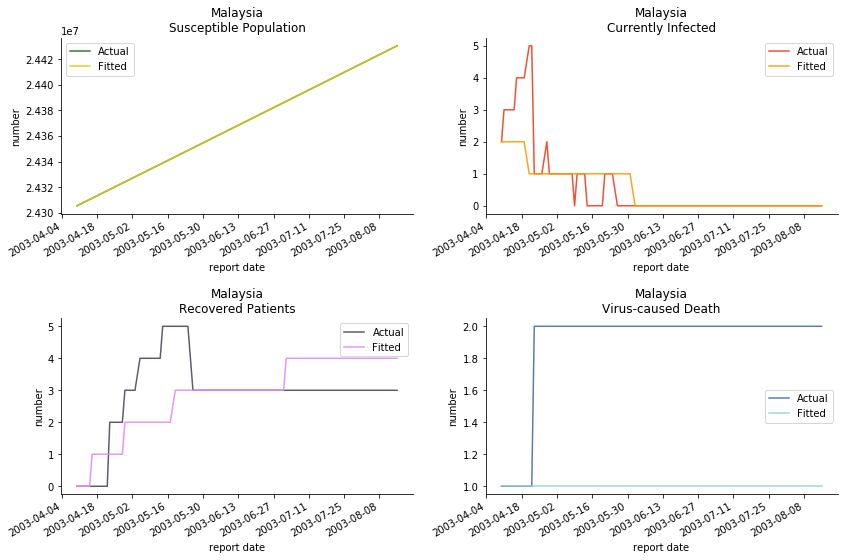

In [26]:
data=datamy.copy(deep=True)

if create_in_sample_output(diagnosis=True):
    plot_all()

C:\ProgramData\Anaconda3\lib\site-packages\scipy\integrate\odepack.py:236: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)



Infection Rate: 5e-10
Fatality Rate: 0.02228
Recovery Rate: 0.03263


Basic Reproductive Ratio: 0.56268



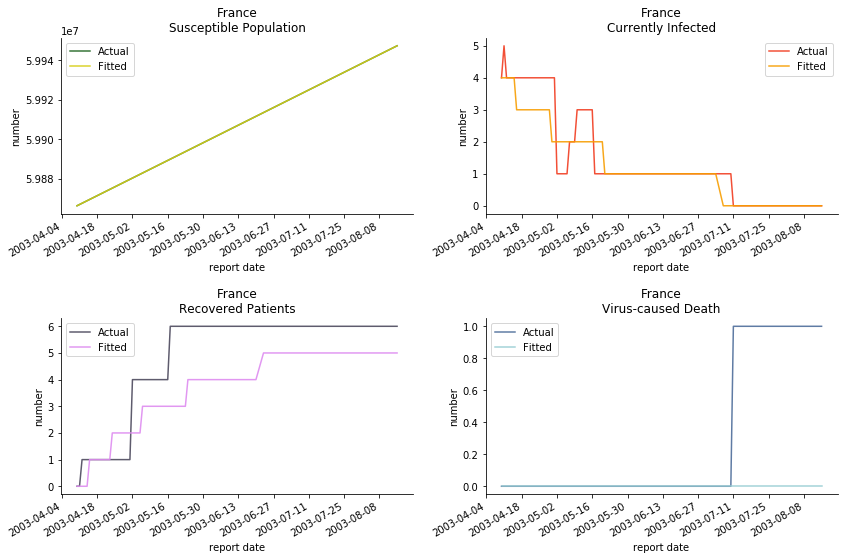

In [27]:
data=datafr.copy(deep=True)

if create_in_sample_output(diagnosis=True):
    plot_all()

&nbsp;
### Out-of-sample Data
&nbsp;

In [28]:
train_init=[(0.001,0.0009,0.05)]*5

In [29]:
train_init3=[(8.8e-08,0.015,0.04)]*5

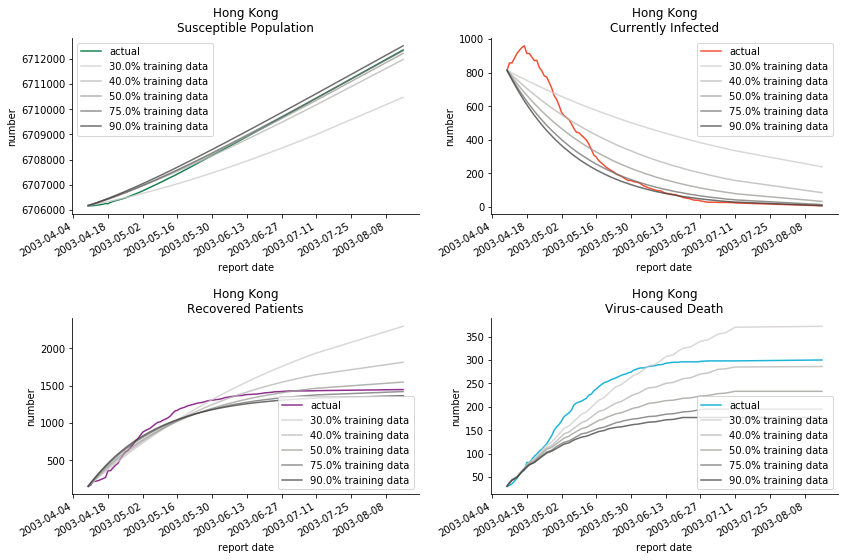

In [30]:
data=datahk.copy(deep=True)

create_outta_sample_output(train_init=train_init3)

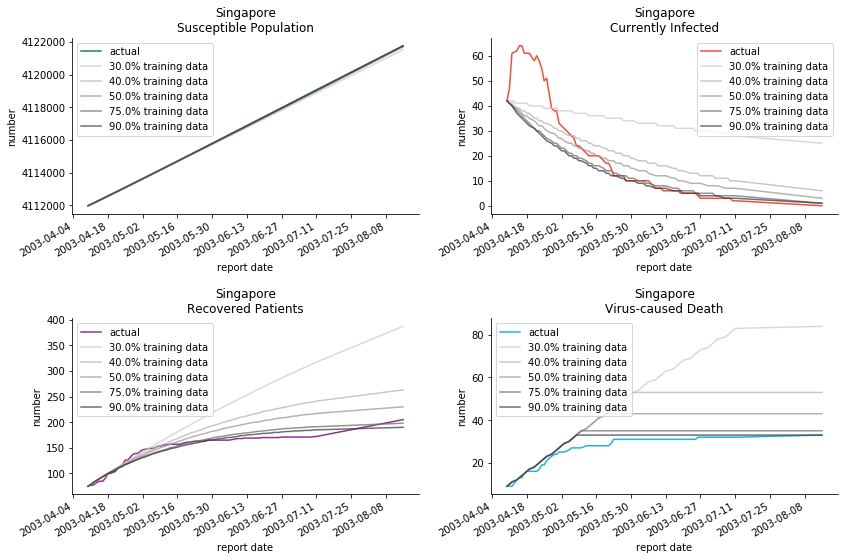

In [31]:
data=datasg.copy(deep=True)
create_outta_sample_output(train_init=train_init3)

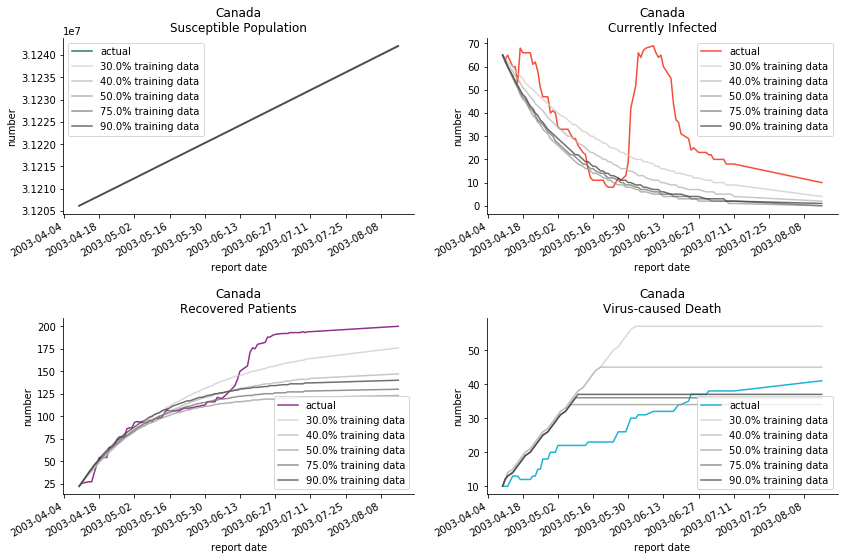

In [32]:
data=dataca.copy(deep=True)
create_outta_sample_output(train_init=train_init3)

C:\ProgramData\Anaconda3\lib\site-packages\scipy\integrate\odepack.py:236: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


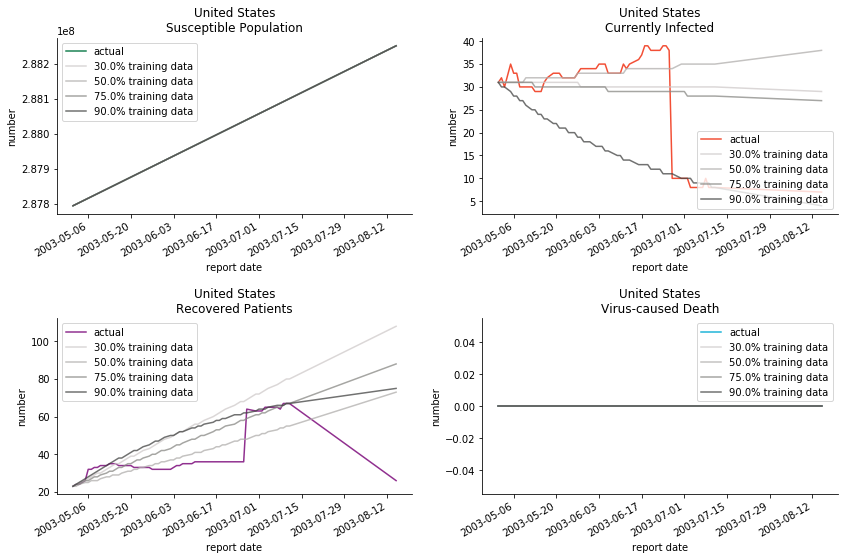

In [33]:
data=dataus.copy(deep=True)
create_outta_sample_output(train_init=train_init)

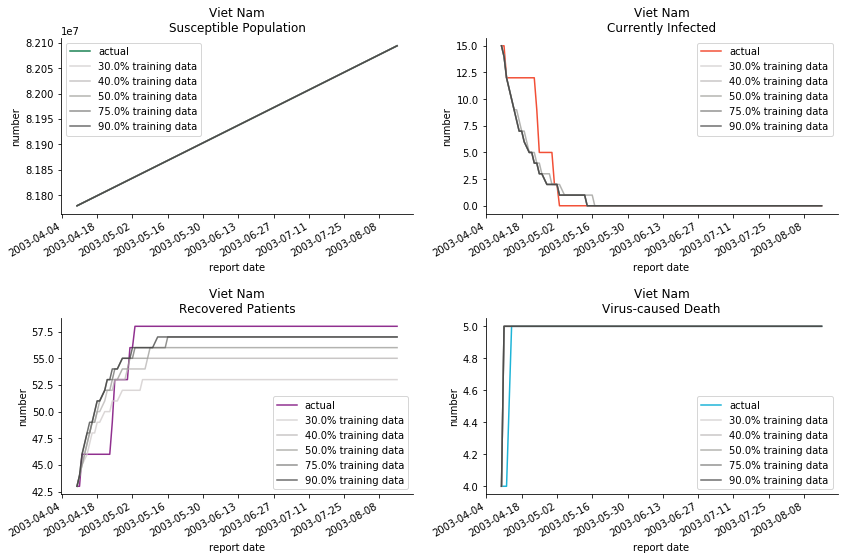

In [34]:
data=datavn.copy(deep=True)
create_outta_sample_output(train_init=train_init3)

C:\ProgramData\Anaconda3\lib\site-packages\scipy\integrate\odepack.py:236: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


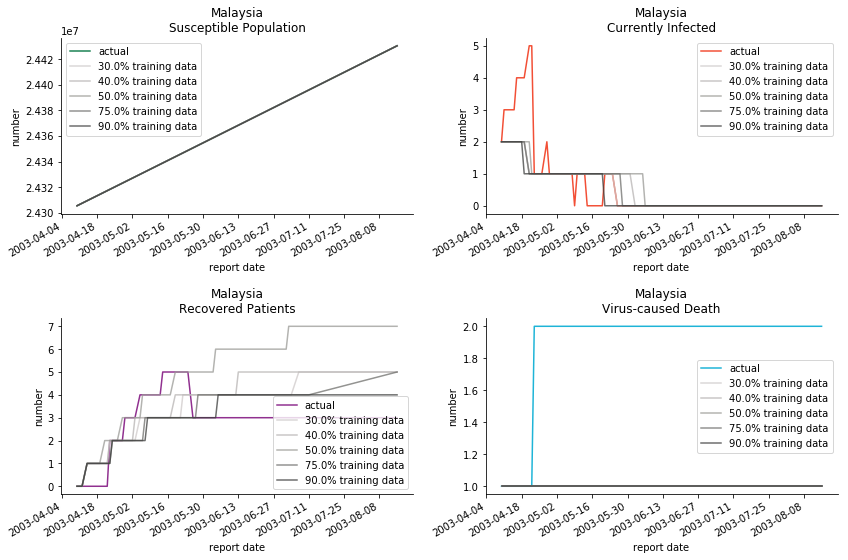

In [35]:
data=datamy.copy(deep=True)
create_outta_sample_output()

C:\ProgramData\Anaconda3\lib\site-packages\scipy\integrate\odepack.py:236: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


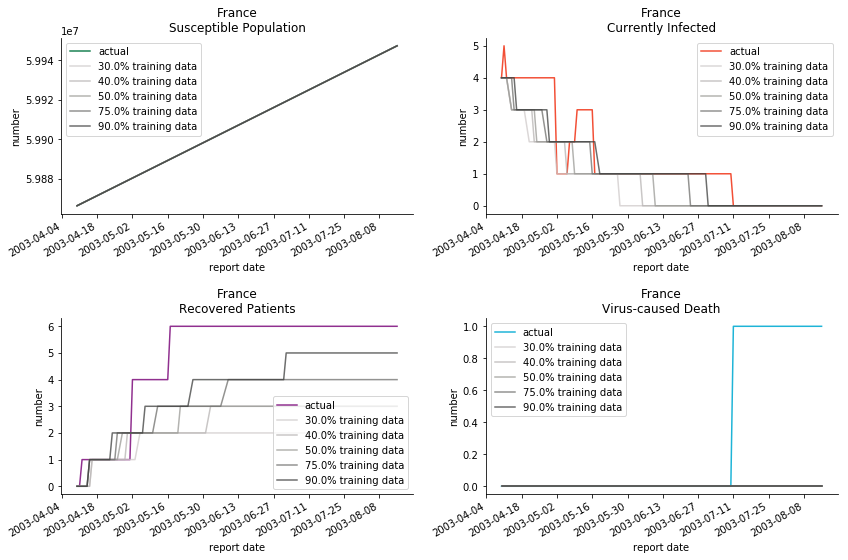

In [36]:
data=datafr.copy(deep=True)
create_outta_sample_output()